<a href="https://colab.research.google.com/github/vfantacone/jafamo/blob/master/SDNTraffic_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

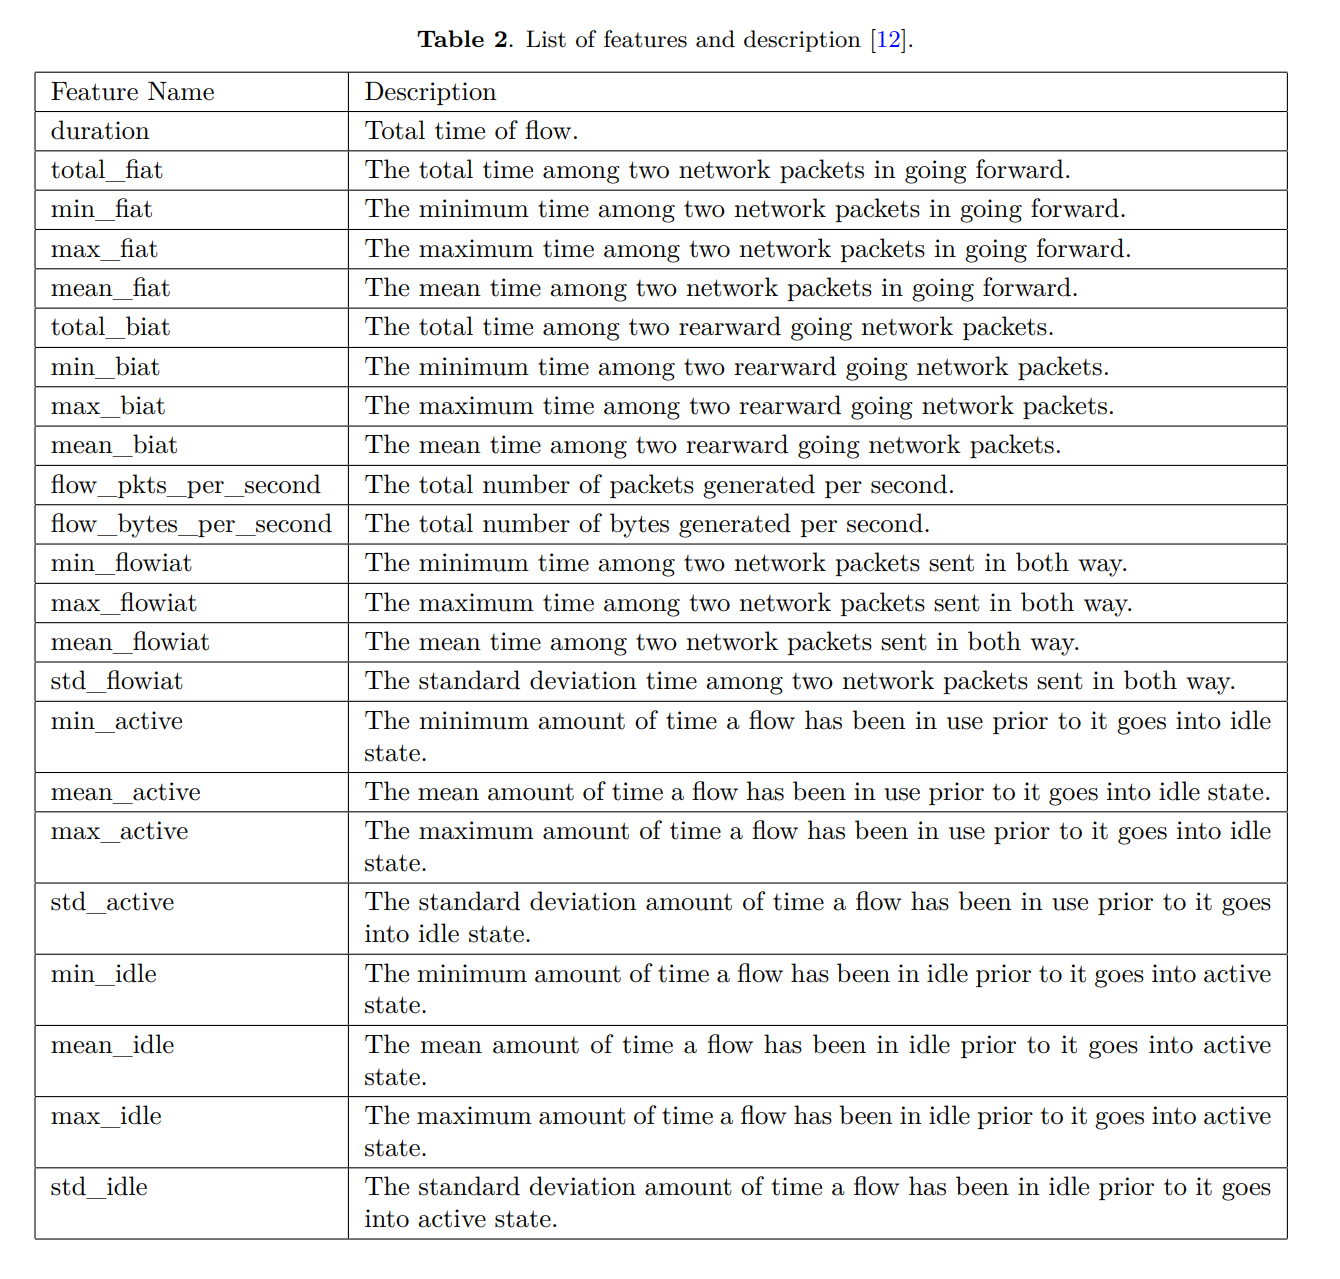

In [ ]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
#from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn. metrics import accuracy_score
from keras.utils.vis_utils import plot_model

In [ ]:
!pip install visualkeras
import visualkeras 


     |████████████████████████████████| 992 kB 32.6 MB/s 


In [ ]:
# Read the Dataset in .arff Format
from scipy.io import arff

data = arff.loadarff('/content/drive/MyDrive/Neural-Network-for-NM/Datasets/ISCX/ISCX/Scenario A2/TimeBasedFeatures-Dataset-30s-NO-VPN.arff')
df = pd.DataFrame(data[0])

#save dataframe to csv file
# df.to_csv("/content/drive/MyDrive/Neural-Network-for-NM/Datasets/ISCX/ISCX/Scenario B/TimeBasedFeatures-Dates-120s-AllinOne.csv")

df.head()
df.shape

(6917, 24)

In [ ]:
df.sample(30)

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle,class1
6325,29998789.0,29996525.0,29981930.0,143.0,2.0,37155.0,32693.0,1.836897e+04,1.698693e+04,113.337908,...,5.780501e+03,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,b'VOIP'
4838,264.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.000000e+00,0.000000e+00,7575.757576,...,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,b'P2P'
5090,328.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.000000e+00,0.000000e+00,6097.560976,...,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,b'P2P'
6198,29987409.0,29987409.0,29977844.0,138.0,0.0,37954.0,39486.0,1.831851e+04,1.701353e+04,113.414267,...,5.582189e+03,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,b'VOIP'
4830,288.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,0.000000e+00,0.000000e+00,6944.444444,...,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,b'P2P'
3481,8734264.0,8734264.0,8733888.0,2.0,3.0,4761244.0,4836778.0,2.074105e+02,2.141079e+02,9491.927425,...,1.653814e+04,4870476.0,4.870476e+06,4870476.0,0.000000e+00,4761244.0,4.761244e+06,4761244.0,0.000000e+00,b'FT'
2054,32874.0,32874.0,2469.0,6.0,12.0,32868.0,2457.0,1.643700e+04,1.234500e+03,182.515057,...,1.335353e+04,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,b'BROWSING'
960,311199.0,286221.0,284169.0,73.0,3.0,187052.0,121317.0,1.908140e+04,1.894460e+04,102.828094,...,2.502219e+04,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,-1.0,0.000000e+00,b'BROWSING'
510,29105030.0,29104689.0,29103793.0,78.0,2.0,6593470.0,6643852.0,4.157813e+05,3.270089e+05,5.531690,...,7.455752e+05,1344792.0,4.832805e+06,7660227.0,2.598950e+06,1023560.0,3.357386e+06,6593470.0,1.989341e+06,b'BROWSING'
1753,6590197.0,6579053.0,6590197.0,2.0,83.0,4860656.0,4864525.0,4.699324e+05,5.991088e+05,4.096994,...,9.557739e+05,6436039.0,6.436039e+06,6436039.0,0.000000e+00,4860592.0,4.860592e+06,4860592.0,0.000000e+00,b'BROWSING'


In [ ]:
print(df['class1'])

0       b'BROWSING'
1       b'BROWSING'
2       b'BROWSING'
3       b'BROWSING'
4       b'BROWSING'
           ...     
6912        b'VOIP'
6913        b'VOIP'
6914        b'VOIP'
6915        b'VOIP'
6916        b'VOIP'
Name: class1, Length: 6917, dtype: object


In [ ]:
# Convert the class1 data type from "object" to "string"
df['class1'] = df['class1'].astype('str')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6917 entries, 0 to 6916
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   duration            6917 non-null   float64
 1   total_fiat          6917 non-null   float64
 2   total_biat          6917 non-null   float64
 3   min_fiat            6917 non-null   float64
 4   min_biat            6917 non-null   float64
 5   max_fiat            6917 non-null   float64
 6   max_biat            6917 non-null   float64
 7   mean_fiat           6917 non-null   float64
 8   mean_biat           6917 non-null   float64
 9   flowPktsPerSecond   6917 non-null   float64
 10  flowBytesPerSecond  6917 non-null   float64
 11  min_flowiat         6917 non-null   float64
 12  max_flowiat         6917 non-null   float64
 13  mean_flowiat        6917 non-null   float64
 14  std_flowiat         6917 non-null   float64
 15  min_active          6917 non-null   float64
 16  mean_a

In [ ]:
df.dropna(inplace=True) # find and replace missing value in a column with NA
df.isna().sum()  # returns the number of missing values in each column

duration              0
total_fiat            0
total_biat            0
min_fiat              0
min_biat              0
max_fiat              0
max_biat              0
mean_fiat             0
mean_biat             0
flowPktsPerSecond     0
flowBytesPerSecond    0
min_flowiat           0
max_flowiat           0
mean_flowiat          0
std_flowiat           0
min_active            0
mean_active           0
max_active            0
std_active            0
min_idle              0
mean_idle             0
max_idle              0
std_idle              0
class1                0
dtype: int64

In [ ]:
df.shape

(6917, 24)

In [ ]:
# creating dummy variables for the class1 column to make our algorithm more efficient

# substring to be searched
sub = ['CHAT', 'FT', 'MAIL', 'STREAMING', 'VOIP', 'P2P', 'BROWSING']
sub1 = ["CHAT", "FT", "MAIL", "STREAMING", "VOIP", "P2P", "BROWSING"]

for column in range(7):
  # creating and passing series to new column as 0 and 1
  df[sub1[column]] = df['class1'].str.find(sub[column]) # if the string in the original column does not contain the substring "sub[column]" 
                                                        # add a -1 in the corresponding raw of the new column
  for row in range(df.shape[0]):
    if df[sub[column]][row]!=-1:
      df[sub[column]][row] = 1
    else:
      df[sub[column]][row] = 0

# display
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,max_idle,std_idle,class1,CHAT,FT,MAIL,STREAMING,VOIP,P2P,BROWSING
0,29999857.0,29999857.0,29975545.0,1.0,0.0,1014690.0,1016593.0,1756.329079,368.530638,3280.715638,...,1014624.0,0.000000e+00,b'BROWSING',0,0,0,0,0,0,1
1,29882813.0,29882777.0,29873072.0,2.0,0.0,1399330.0,1211310.0,2145.826296,454.170612,2667.185315,...,1208289.0,3.159205e+04,b'BROWSING',0,0,0,0,0,0,1
2,29998247.0,29998247.0,29971049.0,0.0,0.0,957051.0,757034.0,1861.741885,457.608199,2720.492301,...,-1.0,0.000000e+00,b'BROWSING',0,0,0,0,0,0,1
3,29997301.0,29997301.0,29971643.0,0.0,0.0,823486.0,854818.0,1589.345184,512.449655,2578.998691,...,-1.0,0.000000e+00,b'BROWSING',0,0,0,0,0,0,1
4,29999559.0,29999510.0,29999530.0,7.0,0.0,442870.0,472021.0,7451.443120,1404.209418,846.412442,...,-1.0,0.000000e+00,b'BROWSING',0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,29995874.0,29980213.0,29983832.0,77.0,0.0,21226.0,31061.0,19723.824342,19713.236029,101.447286,...,-1.0,0.000000e+00,b'VOIP',0,0,0,0,1,0,0
6913,29999936.0,29999936.0,29975821.0,66.0,111.0,21465.0,28475.0,19646.323510,19733.917709,101.600217,...,-1.0,0.000000e+00,b'VOIP',0,0,0,0,1,0,0
6914,400609.0,400609.0,200451.0,400609.0,200451.0,400609.0,200451.0,400609.000000,200451.000000,9.984798,...,-1.0,0.000000e+00,b'VOIP',0,0,0,0,1,0,0
6915,9542653.0,9532711.0,9542653.0,154.0,331.0,4064711.0,4227067.0,136181.585714,136323.614286,14.880558,...,4064711.0,1.189803e+06,b'VOIP',0,0,0,0,1,0,0


----------- Drop of columns that are considered non relevant --------------

In [ ]:
# df.drop(['min_fiat', 'min_biat', 'class1', 'flowBytesPerSecond', 'std_flowiat', 'flowPktsPerSecond', 'mean_idle', 'min_idle', 'max_idle'], axis=1, inplace=True)  
df.drop(['class1'], axis=1, inplace=True)
df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,mean_idle,max_idle,std_idle,CHAT,FT,MAIL,STREAMING,VOIP,P2P,BROWSING
0,29999857.0,29999857.0,29975545.0,1.0,0.0,1014690.0,1016593.0,1756.329079,368.530638,3280.715638,...,1014624.0,1014624.0,0.000000,0,0,0,0,0,0,1
1,29882813.0,29882777.0,29873072.0,2.0,0.0,1399330.0,1211310.0,2145.826296,454.170612,2667.185315,...,1170766.0,1208289.0,31592.045017,0,0,0,0,0,0,1
2,29998247.0,29998247.0,29971049.0,0.0,0.0,957051.0,757034.0,1861.741885,457.608199,2720.492301,...,0.0,-1.0,0.000000,0,0,0,0,0,0,1
3,29997301.0,29997301.0,29971643.0,0.0,0.0,823486.0,854818.0,1589.345184,512.449655,2578.998691,...,0.0,-1.0,0.000000,0,0,0,0,0,0,1
4,29999559.0,29999510.0,29999530.0,7.0,0.0,442870.0,472021.0,7451.443120,1404.209418,846.412442,...,0.0,-1.0,0.000000,0,0,0,0,0,0,1


In [ ]:
scaler = MinMaxScaler() # This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

df_std= scaler.fit_transform(df)
df_std

df_std.shape

(6917, 30)

In [ ]:
df_std

array([[0.09880777, 0.09880777, 0.22609612, ..., 0.        , 0.        ,
        1.        ],
       [0.09842227, 0.09842215, 0.22532319, ..., 0.        , 0.        ,
        1.        ],
       [0.09880246, 0.09880246, 0.2260622 , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.00131945, 0.00131945, 0.00151194, ..., 1.        , 0.        ,
        0.        ],
       [0.03142976, 0.03139701, 0.07197723, ..., 1.        , 0.        ,
        0.        ],
       [0.02724773, 0.02724773, 0.06090194, ..., 1.        , 0.        ,
        0.        ]])

In [ ]:
new_df = pd.DataFrame(df_std, columns=df.columns)
new_df.head()

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,mean_idle,max_idle,std_idle,CHAT,FT,MAIL,STREAMING,VOIP,P2P,BROWSING
0,0.098808,0.098808,0.226096,5.307745e-08,2.325453e-08,0.003342,0.007687,0.000012,0.000009,0.003281,...,0.003338,0.003342,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.098422,0.098422,0.225323,7.961617e-08,2.325453e-08,0.004609,0.009159,0.000014,0.000011,0.002667,...,0.003851,0.003980,0.000352,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.098802,0.098802,0.226062,2.653872e-08,2.325453e-08,0.003152,0.005724,0.000012,0.000011,0.002720,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.098799,0.098799,0.226067,2.653872e-08,2.325453e-08,0.002712,0.006463,0.000010,0.000012,0.002579,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.098807,0.098807,0.226277,2.123098e-07,2.325453e-08,0.001459,0.003569,0.000049,0.000033,0.000846,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
new_df

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,mean_idle,max_idle,std_idle,CHAT,FT,MAIL,STREAMING,VOIP,P2P,BROWSING
0,0.098808,0.098808,0.226096,5.307745e-08,2.325453e-08,0.003342,0.007687,0.000012,0.000009,0.003281,...,0.003338,0.003342,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.098422,0.098422,0.225323,7.961617e-08,2.325453e-08,0.004609,0.009159,0.000014,0.000011,0.002667,...,0.003851,0.003980,0.000352,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.098802,0.098802,0.226062,2.653872e-08,2.325453e-08,0.003152,0.005724,0.000012,0.000011,0.002720,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.098799,0.098799,0.226067,2.653872e-08,2.325453e-08,0.002712,0.006463,0.000010,0.000012,0.002579,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.098807,0.098807,0.226277,2.123098e-07,2.325453e-08,0.001459,0.003569,0.000049,0.000033,0.000846,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,0.098795,0.098743,0.226159,2.070020e-06,2.325453e-08,0.000070,0.000235,0.000130,0.000458,0.000101,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6913,0.098808,0.098808,0.226098,1.778094e-06,2.604507e-06,0.000071,0.000215,0.000129,0.000459,0.000102,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6914,0.001319,0.001319,0.001512,1.063168e-02,4.661417e-03,0.001320,0.001516,0.002636,0.004662,0.000010,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6915,0.031430,0.031397,0.071977,4.113502e-06,7.720503e-06,0.013389,0.031961,0.000896,0.003170,0.000015,...,0.008851,0.013389,0.013249,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
new_df.shape

(6917, 30)

In [ ]:
# spliting our dataset into input X and output Y variables

X = new_df.iloc[:,0:23].astype(float)

y = new_df.iloc[:,23:30]

X

,duration,total_fiat,total_biat,min_fiat,min_biat,max_fiat,max_biat,mean_fiat,mean_biat,flowPktsPerSecond,...,mean_flowiat,std_flowiat,min_active,mean_active,max_active,std_active,min_idle,mean_idle,max_idle,std_idle
0,0.098808,0.098808,0.226096,5.307745e-08,2.325453e-08,0.003342,0.007687,0.000012,0.000009,0.003281,...,0.000005,0.000055,0.031546,0.031507,0.031546,0.000000,0.003342,0.003338,0.003342,0.000000
1,0.098422,0.098422,0.225323,7.961617e-08,2.325453e-08,0.004609,0.009159,0.000014,0.000011,0.002667,...,0.000006,0.000089,0.005774,0.021995,0.062632,0.092041,0.003733,0.003851,0.003980,0.000352
2,0.098802,0.098802,0.226062,2.653872e-08,2.325453e-08,0.003152,0.005724,0.000012,0.000011,0.002720,...,0.000006,0.000057,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.098799,0.098799,0.226067,2.653872e-08,2.325453e-08,0.002712,0.006463,0.000010,0.000012,0.002579,...,0.000006,0.000056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.098807,0.098807,0.226277,2.123098e-07,2.325453e-08,0.001459,0.003569,0.000049,0.000033,0.000846,...,0.000019,0.000051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6912,0.098795,0.098743,0.226159,2.070020e-06,2.325453e-08,0.000070,0.000235,0.000130,0.000458,0.000101,...,0.000162,0.000030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6913,0.098808,0.098808,0.226098,1.778094e-06,2.604507e-06,0.000071,0.000215,0.000129,0.000459,0.000102,...,0.000162,0.000030,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6914,0.001319,0.001319,0.001512,1.063168e-02,4.661417e-03,0.001320,0.001516,0.002636,0.004662,0.000010,...,0.002200,0.000849,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6915,0.031430,0.031397,0.071977,4.113502e-06,7.720503e-06,0.013389,0.031961,0.000896,0.003170,0.000015,...,0.001115,0.003041,0.006600,0.010463,0.018223,0.022736,0.006599,0.008851,0.013389,0.013249


In [ ]:
y

,CHAT,FT,MAIL,STREAMING,VOIP,P2P,BROWSING
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
6912,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6913,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6914,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6915,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Univariate Selection

https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

           Specs       Score
3       min_fiat  320.825003
2     total_biat  243.444220
11   min_flowiat  236.942863
4       min_biat  236.636917
8      mean_biat  153.063727
13  mean_flowiat  132.261061
21      max_idle  112.686312
17    max_active  112.075061
6       max_biat  110.554430
12   max_flowiat  109.798555


Feature Importance

[0.07453137 0.07582444 0.07499766 0.0459017  0.0363391  0.04614986
 0.04757633 0.05618372 0.04128565 0.03954288 0.06077415 0.06033535
 0.05885811 0.06763714 0.04821108 0.02235947 0.02276347 0.02236855
 0.01068215 0.02431193 0.0230337  0.02609573 0.01423647]


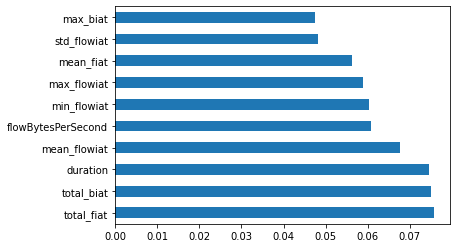

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Correlation Matrix with Heatmap

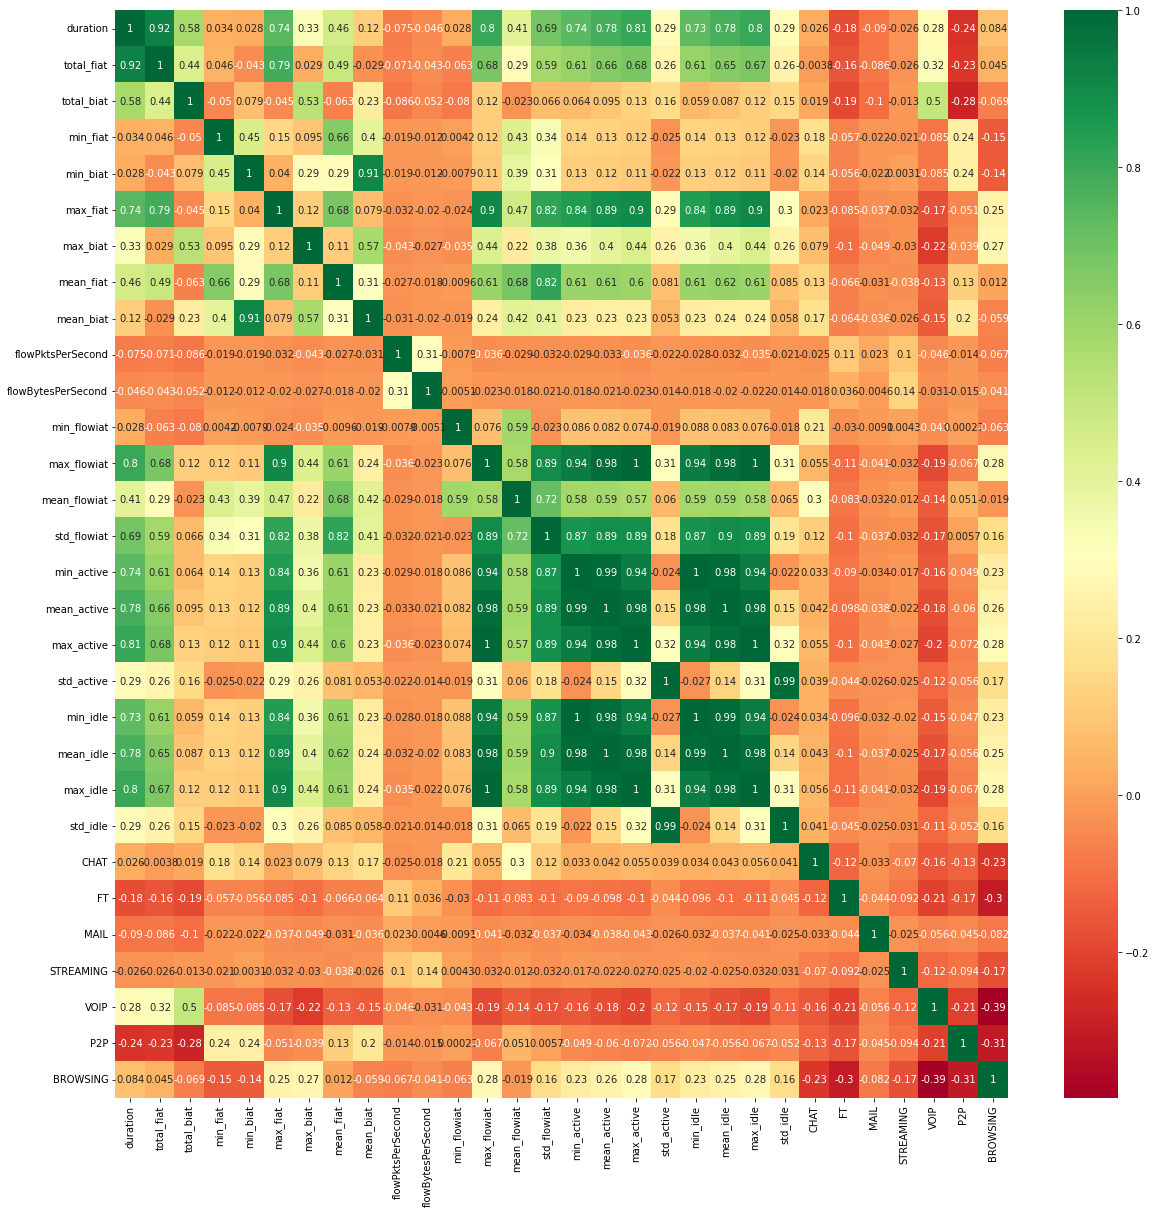

In [ ]:
import seaborn as sns

#get correlations of each features in dataset
corrmat = new_df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(new_df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [ ]:
my_list = list(X) # convert X in a list
print(my_list)

['duration', 'total_fiat', 'total_biat', 'min_fiat', 'min_biat', 'max_fiat', 'max_biat', 'mean_fiat', 'mean_biat', 'flowPktsPerSecond', 'flowBytesPerSecond', 'min_flowiat', 'max_flowiat', 'mean_flowiat', 'std_flowiat', 'min_active', 'mean_active', 'max_active', 'std_active', 'min_idle', 'mean_idle', 'max_idle', 'std_idle']


In [ ]:
# Principal Component Analysis, PCA, of the features

import matplotlib.pyplot as plt
import seaborn as sns

# load decomposition to do PCA analysis with sklearn
from sklearn import decomposition

NumPCA_Components = 23 # we consider 23 Components = to the number of features/inputs of the model

pca = decomposition.PCA(n_components=NumPCA_Components)
pc = pca.fit_transform(X)

In [ ]:
pc_df = pd.DataFrame(data = pc) # put the PC in a dataframe
pc_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
0,0.005307,-0.009966,0.122408,0.052467,0.026590,-0.035208,-0.026982,-0.007629,0.007958,-0.013921,...,0.025565,-0.021503,0.010769,0.002016,-0.008819,-0.000284,0.000591,-0.000316,-0.000123,-0.000079
1,0.011538,-0.011343,0.131308,0.051037,0.000376,0.028147,-0.034228,-0.007923,0.007176,-0.023476,...,0.074269,0.027285,-0.006214,0.001825,-0.002924,-0.001691,0.001791,0.007527,0.005075,-0.000470
2,-0.025494,0.000110,0.128804,0.061127,0.026311,-0.028168,-0.035565,0.001144,0.005931,-0.004809,...,-0.002732,0.000019,-0.001160,-0.000856,0.000277,0.000963,0.000555,-0.001171,0.000804,0.000027
3,-0.025402,0.000345,0.128993,0.060824,0.026328,-0.028084,-0.035058,0.001134,0.005434,-0.004926,...,-0.002849,0.000189,-0.000858,-0.001166,0.000245,0.000760,0.000583,-0.001318,0.000902,0.000030
4,-0.026540,0.000042,0.128787,0.061918,0.026785,-0.028549,-0.036670,0.001246,0.002211,-0.006403,...,-0.002314,-0.000300,-0.001223,-0.001110,0.000244,0.000234,0.000507,-0.000562,0.000369,0.000006


In [ ]:
pc_histo = pca.explained_variance_ratio_ # Percentage of variance explained by each of the selected components
pc_histo.shape
pc_histo

array([4.23417100e-01, 1.73357143e-01, 1.60701058e-01, 6.93331056e-02,
       5.63611307e-02, 5.15956172e-02, 3.87396913e-02, 7.63967418e-03,
       7.20261912e-03, 3.93746290e-03, 3.75431133e-03, 2.05210702e-03,
       8.00341319e-04, 4.72179179e-04, 1.83336115e-04, 1.70526394e-04,
       1.31719423e-04, 1.01693712e-04, 3.11176383e-05, 1.26224929e-05,
       3.29536363e-06, 1.47448936e-06, 6.74215570e-07])

In [ ]:
# riempie una lista con numeri in un range prestabilito. ?????? SERVE ?????

search_list = []
search_list.extend(range(1, 101)) # [1,2,3,4,5,6,...,98,99,100]
print(search_list)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


[0.42341709972659186, 0.17335714288489262, 0.16070105764540774, 0.06933310564123357, 0.05636113070093839, 0.05159561718848776, 0.03873969132560935, 0.0076396741832686545, 0.007202619115593438, 0.0039374628961358765, 0.0037543113295294144, 0.002052107020038698, 0.0008003413192647722, 0.0004721791793958484, 0.00018333611519890226, 0.00017052639399994487, 0.00013171942308256692, 0.00010169371164287152, 3.111763825925257e-05, 1.2622492863306442e-05, 3.2953636323311243e-06, 1.4744893627955897e-06, 6.742155697605928e-07]


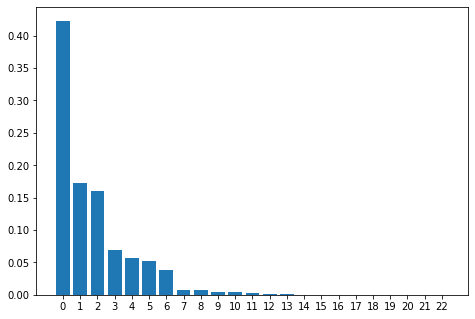

In [ ]:
# drawing the histogram

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22']

variance = pc_histo.tolist()
print(variance)
ax.bar(langs, variance)
plt.show()

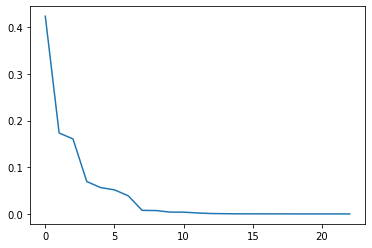

In [ ]:
plt.plot(variance)

In [ ]:
## get the name of the top 10 measurements (features) that contribute
## most to pc0
## first, get the loading scores
loading_scores = pd.Series(pca.components_[0], index=my_list)
## now sort the loading scores based on their magnitude
sorted_loading_scores = loading_scores.abs().sort_values(ascending=False)
 
# get the names of the top 10 genes
top_10_features = sorted_loading_scores[0:10].index.values
 
## print the gene names and their scores (and +/- sign)
print(loading_scores[top_10_features])

max_active     0.302500
max_idle       0.300830
max_flowiat    0.300398
duration       0.297518
mean_active    0.287599
mean_idle      0.286045
min_active     0.274757
min_idle       0.273315
max_fiat       0.247394
total_fiat     0.243722
dtype: float64


In [ ]:
# spliting our dataset into a training set (80%) and a test set (20%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

--------- Decision Tree Prediction ----------


In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
predictions = model.predict(X_test)
score = accuracy_score(y_test, predictions)
score

0.8807803468208093

------------------- Neural Network -----------------------

In [ ]:
# defining our Neural Network model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation

model = Sequential()
model.add(Dense(128, input_shape=(23,), activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(BatchNormalization())
#model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(7, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 128)               3072      
                                                                 
 dense_11 (Dense)            (None, 512)               66048     
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                      

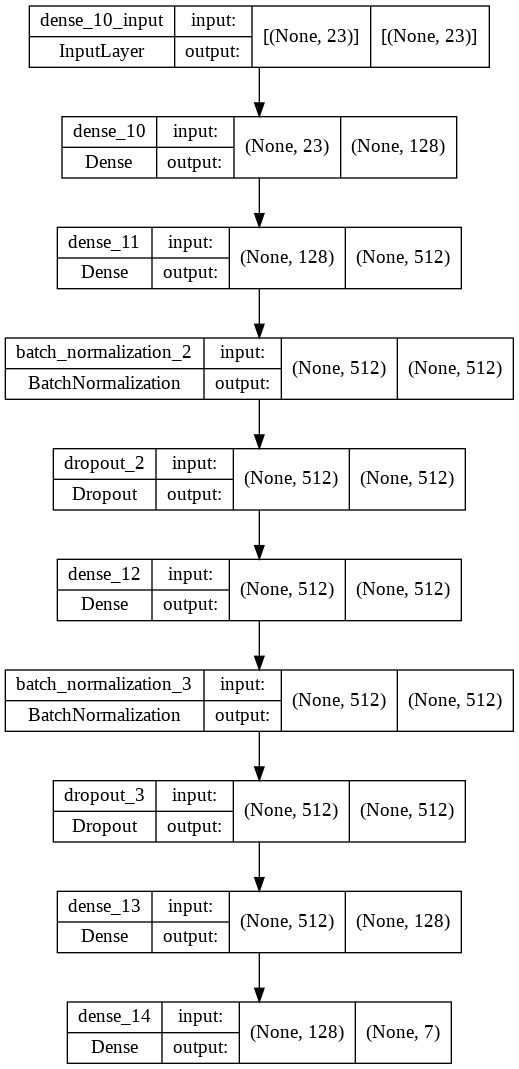

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# This callback will stop the training when there is no improvement in the validation loss for 5 consecutive epochs.  
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=200,
    restore_best_weights=True
)

In [ ]:
# We used binary crosentropy to calculate the loss at each epoch of training and Adam optimizer

model.compile(loss='binary_crossentropy', 
              optimizer='Adam', 
              metrics=['accuracy'])

In [ ]:
# we train our model

model.fit(X_train, 
          y_train, 
          epochs=500,
          batch_size=250, 
          verbose=1, 
          validation_split=0.2,
          callbacks=[es])

Epoch 1/500
18/18 [==============================] - 2s 41ms/step - loss: 0.4250 - accuracy: 0.5172 - val_loss: 0.6202 - val_accuracy: 0.3541
Epoch 2/500
18/18 [==============================] - 0s 26ms/step - loss: 0.2625 - accuracy: 0.6116 - val_loss: 0.5671 - val_accuracy: 0.3704
Epoch 3/500
18/18 [==============================] - 0s 27ms/step - loss: 0.2459 - accuracy: 0.6374 - val_loss: 0.5219 - val_accuracy: 0.3604
Epoch 4/500
18/18 [==============================] - 0s 25ms/step - loss: 0.2383 - accuracy: 0.6405 - val_loss: 0.4852 - val_accuracy: 0.3406
Epoch 5/500
18/18 [==============================] - 1s 28ms/step - loss: 0.2301 - accuracy: 0.6554 - val_loss: 0.4532 - val_accuracy: 0.3622
Epoch 6/500
18/18 [==============================] - 0s 26ms/step - loss: 0.2222 - accuracy: 0.6731 - val_loss: 0.4316 - val_accuracy: 0.3541
Epoch 7/500
18/18 [==============================] - 0s 25ms/step - loss: 0.2197 - accuracy: 0.6905 - val_loss: 0.4168 - val_accuracy: 0.3297
Epoch 

In [ ]:
history_dict = model.history.history

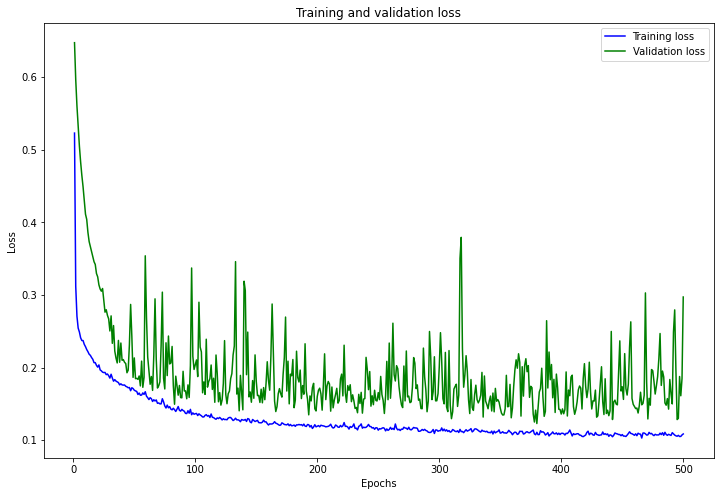

In [ ]:
# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1) 

# plot
plt.figure(figsize=(12, 8))
plt.plot(epochs, loss_values, 'blue',label='Training loss')
plt.plot(epochs, val_loss_values, 'green', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

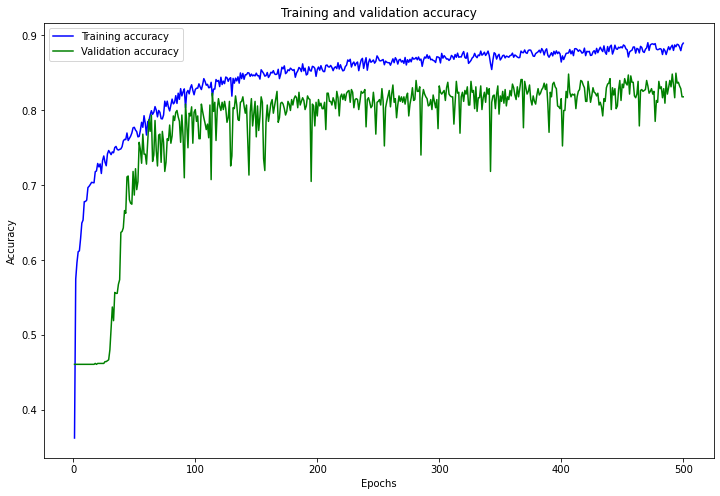

In [ ]:
# accuracy
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

# range of X (no. of epochs)
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 8))
plt.plot(epochs, acc, 'blue',label='Training accuracy')
# orange is for "orange"
plt.plot(epochs, val_acc, 'green', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:

results = model.evaluate(X_test, y_test, batch_size=250)
print("Test set accuracy = {} %".format( results[1]*100))

9/9 [==============================] - 0s 12ms/step - loss: 0.2257 - accuracy: 0.7390
Test set accuracy = 73.89893531799316 %


CONFUSIIN MATRIX

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


preds = np.round(model.predict(X_test),0)

cm = confusion_matrix(y_test.values.argmax(axis=1), preds.argmax(axis=1))

# cm = confusion_matrix(y_test, preds)


cm

array([[ 87,   6,   6,   1,   0,   1,  11],
       [ 90, 117,  37,   2,   1,  26,  30],
       [ 42,   4, 127,   0,   0,   1,   1],
       [ 10,   5,   4,  44,   0,   8,   5],
       [  3,   3,   0,   2, 129,   4,   2],
       [ 56,   6,  11,   5,   3, 241,  22],
       [156,  13,  42,   6,   0,  40, 747]])